In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pgmpy")


In [26]:
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
df = df.drop(columns="MentHlth") # poi eliminare proprio dal dataset 
df = df.drop(columns="PhysHlth") # poi eliminare proprio dal dataset 
df.rename(columns={'Diabetes_012': 'Diabetes'}, inplace=True)
print(df.shape)
df.head(10)

(253680, 20)


,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,8.0,4.0,3.0


In [27]:
X = df.drop(columns=["Diabetes"])  
y = df["Diabetes"]  # La colonna target (0 = no diabete, 1 = diabete)
df["Diabetes"].value_counts()

Diabetes
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [28]:
"""from imblearn.over_sampling import SMOTE

# Separiamo feature (X) e target (y)
X = df.drop(columns=["Diabetes"])  
y = df["Diabetes"]  

# Applichiamo SMOTE solo alla classe 1 (pre-diabetici)
smote = SMOTE(sampling_strategy={1.0: 30000}, random_state=42)  # Portiamo i pre-diabetici a 30,000
X_resampled, y_resampled = smote.fit_resample(X, y)

# Creiamo un nuovo dataframe bilanciato
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Diabetes"] = y_resampled

# Contiamo le nuove distribuzioni
print(df_resampled["Diabetes"].value_counts())"""

'from imblearn.over_sampling import SMOTE\n\n# Separiamo feature (X) e target (y)\nX = df.drop(columns=["Diabetes"])  \ny = df["Diabetes"]  \n\n# Applichiamo SMOTE solo alla classe 1 (pre-diabetici)\nsmote = SMOTE(sampling_strategy={1.0: 30000}, random_state=42)  # Portiamo i pre-diabetici a 30,000\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\n# Creiamo un nuovo dataframe bilanciato\ndf_resampled = pd.DataFrame(X_resampled, columns=X.columns)\ndf_resampled["Diabetes"] = y_resampled\n\n# Contiamo le nuove distribuzioni\nprint(df_resampled["Diabetes"].value_counts())'

In [29]:
from imblearn.under_sampling import RandomUnderSampler

# Sottocampioniamo solo i non diabetici a 100,000 per riequilibrare il dataset
under_sampler = RandomUnderSampler(sampling_strategy={0.0: 40000}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Creiamo il nuovo dataset
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["Diabetes"] = y_resampled
df_resampled["Diabetes"] = df_resampled["Diabetes"].replace({2.0: 1.0})

# Contiamo le nuove distribuzioni
print(df_resampled["Diabetes"].value_counts())
df = df_resampled.copy()


Diabetes
0.0    40000
1.0    39977
Name: count, dtype: int64


In [30]:
df.isna().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
Diabetes                0
dtype: int64

In [31]:
unique_series = df.apply(lambda x: x.unique())
print(unique_series)
print("")
print("="*40)
print("")
print(f"So the columns that we have to discretize are: {df.columns[4]}, {df.columns[15]}, {df.columns[16]}, {df.columns[19]}, {df.columns[19]}")

HighBP                                                         [0.0, 1.0]
HighChol                                                       [0.0, 1.0]
CholCheck                                                      [1.0, 0.0]
BMI                     [24.0, 32.0, 28.0, 35.0, 27.0, 43.0, 47.0, 34....
Smoker                                                         [0.0, 1.0]
Stroke                                                         [0.0, 1.0]
HeartDiseaseorAttack                                           [0.0, 1.0]
PhysActivity                                                   [0.0, 1.0]
Fruits                                                         [0.0, 1.0]
Veggies                                                        [1.0, 0.0]
HvyAlcoholConsump                                              [0.0, 1.0]
AnyHealthcare                                                  [1.0, 0.0]
NoDocbcCost                                                    [0.0, 1.0]
GenHlth                               

In [32]:
print(f"Range of values of BMI: {df['BMI'].min()} - {df['BMI'].max()}")
print(f"Range of values of Age: {df['Age'].min()} - {df['Age'].max()}")
print(f"Range of values of Income: {df['Income'].min()} - {df['Income'].max()}")

Range of values of BMI: 12.0 - 98.0
Range of values of Age: 1.0 - 13.0
Range of values of Income: 1.0 - 8.0


In [33]:
# BMI :
#   - 12<=BMI<=17: underweight = 0
#   - 18<=BMI<=27: normal weight = 1
#   - 28<=BMI<=44: overweight = 2
#   - 45<=BMI: obese = 3

bins = [12, 17, 27, 44, 98]
labels = [0, 1, 2, 3]

df['BMI'] = pd.cut(df['BMI'], bins=bins, labels=labels, include_lowest=True).astype(int)

# Age
#   - 1<=Age<=4: 0 and means between 18 and 35
#   - 5<=Age<=9: 1 and means beatwee 36 and 64
#   - 10<=Age<=17: 2 and means between 65 and 80
#   - 18=Age: 3 and means 81 or older

bins = [1, 4, 9, 17, 18]
labels = [0, 1, 2, 3]

df["Age"] = pd.cut(df["Age"], bins = bins, labels = labels, include_lowest= True).astype(int)

bins = [0,1,2]




In [34]:
df["Age"].unique()

array([1, 0, 2])

In [35]:
COLUMN_NAMES = ["HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack", "PhysActivity",
                "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "GenHlth", "MentHlth",
                "PhysHlth", "DiffWalk", "Sex", "Age", "Education", "Income"]

TARGET = "Diabetes"
df = df.drop(columns=["Income", "Education","Sex","PhysActivity","DiffWalk","CholCheck", "Smoker", "GenHlth", "AnyHealthcare", "NoDocbcCost", "Fruits", "Veggies", "HvyAlcoholConsump"])
df = df.reset_index(drop=True)  # Elimina l'indice precedente e resetta l'ordine
df.head()


,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,Age,Diabetes
0,0.0,0.0,1,0.0,0.0,1,0.0
1,1.0,0.0,2,0.0,0.0,1,0.0
2,1.0,1.0,2,0.0,0.0,1,0.0
3,1.0,1.0,2,0.0,0.0,1,0.0
4,0.0,0.0,2,0.0,0.0,1,0.0


In [36]:
# Define the Bayesian Network
model = BayesianModel([('HighBP', 'Diabetes'), 
                       ('HighChol', 'Diabetes'),
                       ('BMI', 'Diabetes'),
                       ('BMI', 'HighBP'),                       
                       ('BMI', 'HighChol'),
                       ('Diabetes', 'Stroke'),                       
                       ('Diabetes', 'HeartDiseaseorAttack'),
                       ('Age', 'Diabetes'),
                       ('Age', 'HighBP'),
                       ])

In [37]:
# Fit the data to the Bayesian Network to obtain the CPTs
model.fit(df)

In [38]:
for cpd in model.get_cpds():
    print(f'CPT di {cpd.variable}')
    # Convertiamo la CPD in un array numpy per la somma per righe
    cpd_values = np.array(cpd.values)

    # Verifichiamo che la somma delle probabilità sia 1 per ogni combinazione di variabili
    sum_per_row = np.sum(cpd_values, axis=0)  # Asse 0 = somma lungo le righe (per ogni configurazione dei genitori)
    
    print("Somma delle probabilità per ogni combinazione di variabili:")
    print(sum_per_row)  # Ogni valore dovrebbe essere 1
    print('\n')


CPT di HighBP
Somma delle probabilità per ogni combinazione di variabili:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


CPT di Diabetes
Somma delle probabilità per ogni combinazione di variabili:
[[[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]]


CPT di HighChol
Somma delle probabilità per ogni combinazione di variabili:
[1. 1. 1. 1.]


CPT di BMI
Somma delle probabilità per ogni combinazione di variabili:
1.0


CPT di Stroke
Somma delle probabilità per ogni combinazione di variabili:
[1. 1.]


CPT di HeartDiseaseorAttack
Somma delle probabilità per ogni combinazione di variabili:
[1. 1.]


CPT di Age
Somma delle probabilità per ogni combinazione di variabili:
1.0




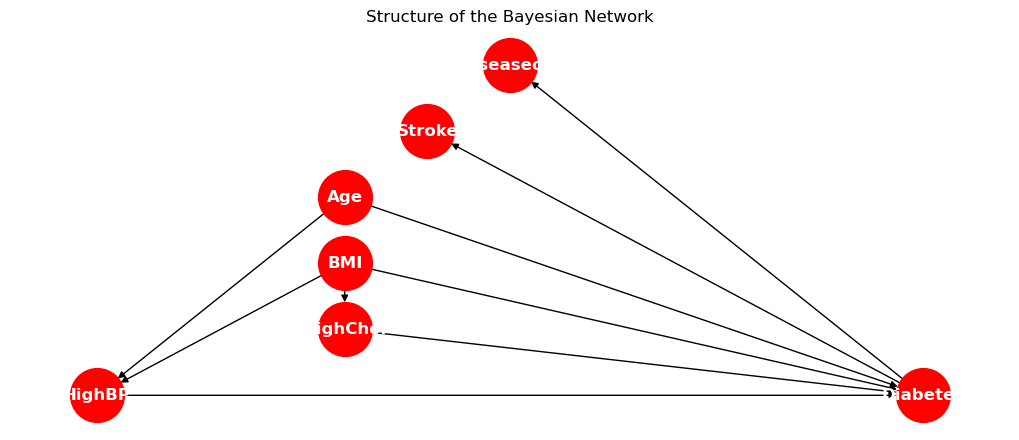

In [39]:
plt.figure(figsize=(10, 4))
nx.draw_planar(model, node_color='r', node_size=1500, with_labels=True, 
               font_color='w', font_weight='bold')
plt.title('Structure of the Bayesian Network')
plt.show()

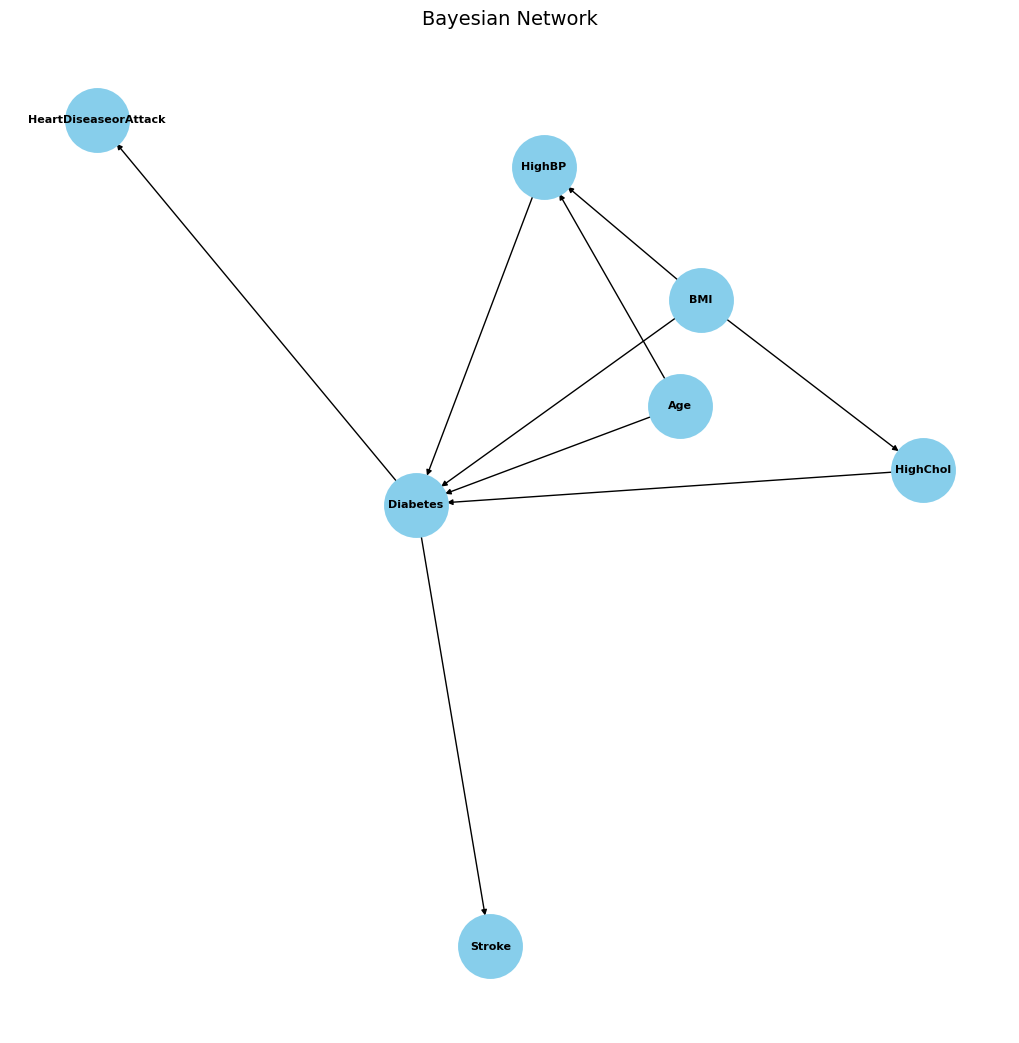

In [40]:
from pgmpy.estimators import BicScore,K2Score

def plot_bayesian_network(model):
    # Ottieni il grafo come NetworkX DiGraph
    nx_graph = nx.DiGraph(model.edges())

    # Usa il layout per migliorare la disposizione
    pos = nx.spring_layout(nx_graph, k=0.7, seed=42)  # k regola la distanza tra i nodi

    # Disegna il grafo
    plt.figure(figsize=(10, 10))  # Aumenta le dimensioni
    nx.draw(nx_graph, pos, with_labels=True, node_color="skyblue",
            node_size=2000, font_size=8, edge_color="black", font_weight="bold",
            arrowsize=8, linewidths=2)

    plt.title("Bayesian Network", fontsize=14)
    plt.show()
plot_bayesian_network(model)



  0%|          | 0/1000000 [00:00<?, ?it/s]

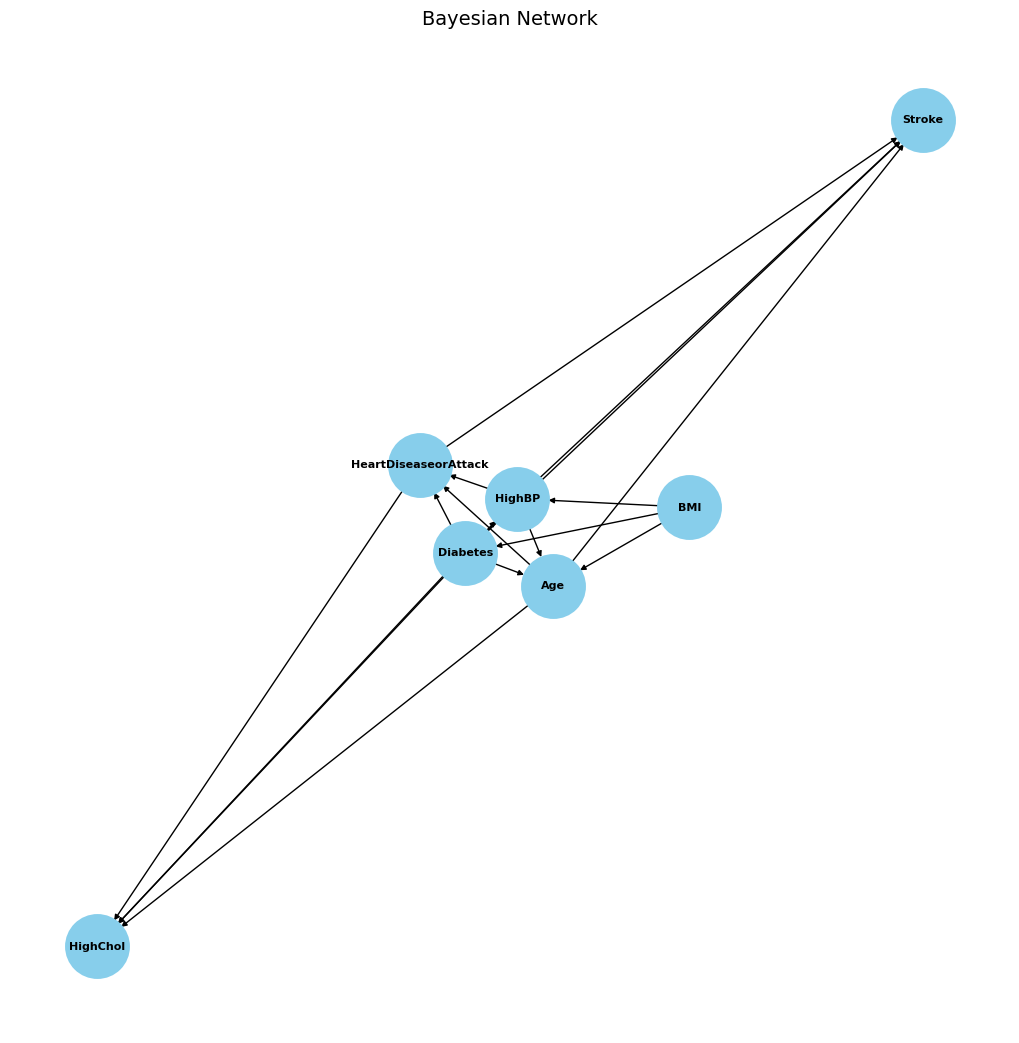

In [41]:
from pgmpy.estimators import HillClimbSearch, BicScore

# Esegui Hill Climbing per trovare la miglior struttura
hc = HillClimbSearch(df)
#scoring_method = BicScore(df)
best_model = hc.estimate(scoring_method="bicscore" )
#best_score = scoring_method.score(best_model)
#print("Score della rete trovata:", best_score)
# Stampa la struttura trovata
plot_bayesian_network(best_model)



Scegliamo il Bayesian network strutturato da noi

In [42]:
from pgmpy.factors.discrete.CPD import TabularCPD


def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup


# Print all the learned CPTs
for cpd in model.get_cpds():
    print('CPT of {}'.format(cpd.variable))
    print_full(cpd)
    print('\n')


CPT of HighBP
+-------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Age         | Age(0)              | Age(0)              | Age(0)             | Age(0)             | Age(1)             | Age(1)              | Age(1)              | Age(1)              | Age(2)             | Age(2)              | Age(2)              | Age(2)              |
+-------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| BMI         | BMI(0)              | BMI(1)              | BMI(2)             | BMI(3)             | BMI(0)             | BMI(1)              | BMI(2)       

Inferenza


Qual è la probabilitá per una persona anziana con con alto livello di colesterolo di avere il diabete?

Quale è la probabilitá di per una persona in sovrappeso con diabete di avere un infarto?

Qual è la probabilitá per una persona con diabete di avere entrambi i valori di colesterolo e Blood pressure alti?

In [43]:
from pgmpy.inference import VariableElimination

# 5. Creazione di un'istanza di VariableElimination
inference = VariableElimination(model)

# 6. Calcolo della probabilità
prob_diabetes = inference.query(variables=["Diabetes"], evidence={"Age": 2, "HighChol":1})
print(prob_diabetes)



+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(0.0) |          0.3274 |
+---------------+-----------------+
| Diabetes(1.0) |          0.6726 |
+---------------+-----------------+


In [52]:

# Quale è la probabilitá di per una persona in sovrappeso con diabete di avere un infarto?
BMIvalues= sorted(df["BMI"].unique())
for i in BMIvalues:
    print(f"BMI = {i} :")
    prob_heart_disease = inference.query(variables=["HeartDiseaseorAttack"], evidence={"BMI": 2, "Diabetes":1})
    print(prob_heart_disease)
    print("\n")


BMI = 0 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.7863 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.2137 |
+---------------------------+-----------------------------+


BMI = 1 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+===========================+=============================+
| HeartDiseaseorAttack(0.0) |                      0.7863 |
+---------------------------+-----------------------------+
| HeartDiseaseorAttack(1.0) |                      0.2137 |
+---------------------------+-----------------------------+


BMI = 2 :
+---------------------------+-----------------------------+
| HeartDiseaseorAttack      |   phi(HeartDiseaseorAttack) |
+=====

In [53]:
#Qual è la probabilitá per una persona con diabete di avere entrambi i valori di colesterolo e Blood pressure alti?
prob_diabetes2 = inference.query(variables=["HighChol", "HighBP"], evidence={"Diabetes":1})
print(prob_diabetes2)

+---------------+-------------+------------------------+
| HighChol      | HighBP      |   phi(HighChol,HighBP) |
+===============+=============+========================+
| HighChol(0.0) | HighBP(0.0) |                 0.1015 |
+---------------+-------------+------------------------+
| HighChol(0.0) | HighBP(1.0) |                 0.2837 |
+---------------+-------------+------------------------+
| HighChol(1.0) | HighBP(0.0) |                 0.1824 |
+---------------+-------------+------------------------+
| HighChol(1.0) | HighBP(1.0) |                 0.4324 |
+---------------+-------------+------------------------+


Approximate Inference is a technique used in probabilistic models when exact inference is computationally prohibitive. In this case our model it is pretty simple so we can use the Exact Inference without problems, but we want to try also the Approximate Inference and check if the results change.

ImportError: cannot import name 'MCMC' from 'pgmpy.inference' (c:\Users\aletr\anaconda3\Lib\site-packages\pgmpy\inference\__init__.py)